In [1]:
import json
import numpy as np
import faiss
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pandas as pd
import time
import joblib

c:\Users\lwinh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
# prepare queries

truths = {
    "How to make Pumpkin Bars with Microwave?": [1428],
    "Show me how to cook Cold Oven Pound Cake with Chocolate.": [13317],
    "How to make banana oatmeal cookies? I have allergy.": [20418],
    "How to make banana oatmeal cookies for people with diabetic": [6406, 15912],
    "How to cook indian beef curry?": [23267],
    "How to cook fish chowder with oven?": [7301, 3831, 12270]
}

In [70]:
def precision_recall_at_k(truths, answers, k = 3):
    precisions = []
    recalls = []

    for q, truth_rows in truths.items():
        answered_rows = answers.get(q, [])[:k]

        correct_rows = len(set(truth_rows) & set(answered_rows))
        total_truths = len(truth_rows)

        precision = correct_rows / k
        recall = correct_rows / total_truths

        precisions.append({
            "query": q,
            "k": k,
            "precision": precision
        })

        recalls.append({
            "query": q,
            "k": k,
            "recall": recall
        })

    return precisions, recalls


In [71]:
minilm_index_path = "files/outputs/recipes-index-all-MiniLM-L6-v2.bin"
text_embedding_index_path = "files/outputs/recipes-index-text-embedding-3-small.bin"
recipe_path = "files/outputs/recipes.jsonl"

In [72]:
# load recipes
recipes = {}
metadatas = []

with open(recipe_path, "r", encoding="utf-8") as f:
    for line in f:
        recipe = json.loads(line)
        recipes[recipe["id"]] = recipe["summary"]
        metadatas.append({ "id": recipe["id"], "row": recipe["row"], "title": recipe["title"]} )

In [73]:
# evaluate minilm first
embedding_model = "all-MiniLM-L6-v2"
index = faiss.read_index(minilm_index_path)
model = SentenceTransformer(embedding_model)
total_k = 3

def retrieve_all_minilm(query, k = total_k):
    qv = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    D, I = index.search(qv, k)

    hits = []
    for score, idx in zip(D[0], I[0]):
        metadata = metadatas[idx]
        hits.append({"score": float(score), "id": metadata["id"], "row": metadata["row"], "title": metadata["title"]})

        if len(hits) >= k:
            break

    return hits


In [74]:
answers = {}

start_time = time.time()
for q in truths.keys():
    hits = retrieve_all_minilm(q, 10)
    
    rows = []
    for h in hits:
        id = h["id"]
        row = h["row"]

        rows.append(row)

    answers[q] = rows
    
end_time = time.time()
print(end_time - start_time)
print(answers)


0.5629568099975586
{'How to make Pumpkin Bars with Microwave?': [6537, 1428, 11610, 5020, 6426, 15213, 29370, 7920, 2663, 1260], 'Show me how to cook Cold Oven Pound Cake with Chocolate.': [21204, 13317, 17597, 26623, 27013, 16093, 15021, 20257, 19829, 28252], 'How to make banana oatmeal cookies? I have allergy.': [20418, 7918, 24357, 7734, 13579, 14063, 20151, 2319, 19851, 1143], 'How to make banana oatmeal cookies for people with diabetic': [15912, 6406, 26484, 29918, 22891, 567, 26921, 15090, 25884, 12487], 'How to cook indian beef curry?': [29186, 23267, 12911, 14035, 19391, 14848, 12797, 8484, 5314, 5019], 'How to cook fish chowder with oven?': [7301, 13255, 7725, 28654, 1128, 13818, 2317, 8625, 11662, 3757]}


In [75]:
k = 3

precisions, recalls = precision_recall_at_k(truths, answers, k)

print(precisions)
print(recalls)

total_precisions = sum(p.get("precision") for p in precisions)
total_recalls = sum(r.get("recall") for r in recalls)

print(f"Average precision - {total_precisions/len(precisions)}")
print(f"Average recall - {total_recalls/len(recalls)}")

[{'query': 'How to make Pumpkin Bars with Microwave?', 'k': 3, 'precision': 0.3333333333333333}, {'query': 'Show me how to cook Cold Oven Pound Cake with Chocolate.', 'k': 3, 'precision': 0.3333333333333333}, {'query': 'How to make banana oatmeal cookies? I have allergy.', 'k': 3, 'precision': 0.3333333333333333}, {'query': 'How to make banana oatmeal cookies for people with diabetic', 'k': 3, 'precision': 0.6666666666666666}, {'query': 'How to cook indian beef curry?', 'k': 3, 'precision': 0.3333333333333333}, {'query': 'How to cook fish chowder with oven?', 'k': 3, 'precision': 0.3333333333333333}]
[{'query': 'How to make Pumpkin Bars with Microwave?', 'k': 3, 'recall': 1.0}, {'query': 'Show me how to cook Cold Oven Pound Cake with Chocolate.', 'k': 3, 'recall': 1.0}, {'query': 'How to make banana oatmeal cookies? I have allergy.', 'k': 3, 'recall': 1.0}, {'query': 'How to make banana oatmeal cookies for people with diabetic', 'k': 3, 'recall': 1.0}, {'query': 'How to cook indian bee

In [76]:
metrics = []
for k in [1, 3, 5, 10]:
    precisions, recalls = precision_recall_at_k(truths, answers, k)

    p_vals = []
    r_vals = []

    for p in precisions:
        p_vals.append(p["precision"])

    for r in recalls:
        r_vals.append(r["recall"])

    avg_p = float(np.mean(p_vals))
    avg_r = float(np.mean(r_vals))

    metrics.append({
        "k": k,
        "precision": avg_p,
        "recall": avg_r
    })

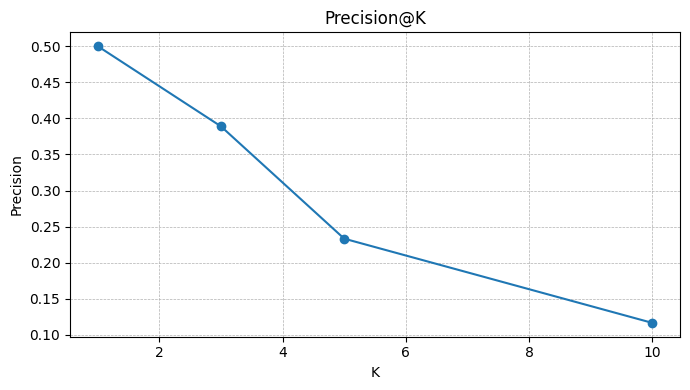

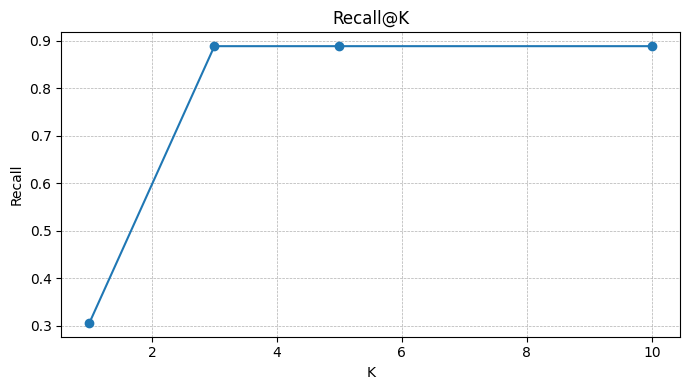

In [77]:
metrics = pd.DataFrame(metrics)

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["precision"], marker="o")
plt.title("Precision@K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["recall"], marker="o")
plt.title("Recall@K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
embedding_model = "text-embedding-3-small"
openai_api_key = "add-your-open-AI-key"
total_k = 3

client = OpenAI(api_key=openai_api_key)
index = faiss.read_index(text_embedding_index_path)

In [79]:
def retrieve_text_embedding(query, k = total_k):
    embed = client.embeddings.create(input=[query], model=embedding_model)
    vectors = []

    for e in embed.data:
        vectors.append(e.embedding)

    vectors = np.array(vectors, dtype=np.float32)
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    qv = vectors / norms
    D, I = index.search(qv, k)

    hits = []
    for score, idx in zip(D[0], I[0]):
        metadata = metadatas[idx]
        hits.append({"score": float(score), "id": metadata["id"], "row": metadata["row"], "title": metadata["title"]})

        if len(hits) >= k:
            break

    return hits


In [80]:
answers = {}

start_time = time.time()
for q in truths.keys():
    hits = retrieve_text_embedding(q, 10)
    
    rows = []
    for h in hits:
        id = h["id"]
        row = h["row"]

        rows.append(row)

    answers[q] = rows

end_time = time.time()
print(end_time - start_time)
print(answers)

3.3148295879364014
{'How to make Pumpkin Bars with Microwave?': [6537, 1428, 6810, 5020, 9419, 11422, 29153, 23013, 17905, 18717], 'Show me how to cook Cold Oven Pound Cake with Chocolate.': [13317, 21204, 24178, 5594, 17597, 18921, 8030, 19829, 15021, 5443], 'How to make banana oatmeal cookies? I have allergy.': [20418, 15912, 14063, 1143, 7734, 23905, 3663, 11704, 24357, 7918], 'How to make banana oatmeal cookies for people with diabetic': [6406, 15912, 15090, 2813, 26921, 26484, 567, 22891, 25884, 20418], 'How to cook indian beef curry?': [23267, 21962, 12878, 24193, 3362, 10839, 5514, 8484, 25341, 5019], 'How to cook fish chowder with oven?': [7301, 7725, 3831, 2317, 5677, 27812, 22238, 21264, 11601, 28654]}


In [81]:
metrics = []
for k in [1, 3, 5, 10]:
    precisions, recalls = precision_recall_at_k(truths, answers, k)

    p_vals = []
    r_vals = []

    for p in precisions:
        p_vals.append(p["precision"])

    for r in recalls:
        r_vals.append(r["recall"])

    avg_p = float(np.mean(p_vals))
    avg_r = float(np.mean(r_vals))

    metrics.append({
        "k": k,
        "precision": avg_p,
        "recall": avg_r
    })

In [82]:
print(metrics)

[{'k': 1, 'precision': 0.8333333333333334, 'recall': 0.638888888888889}, {'k': 3, 'precision': 0.4444444444444444, 'recall': 0.9444444444444445}, {'k': 5, 'precision': 0.26666666666666666, 'recall': 0.9444444444444445}, {'k': 10, 'precision': 0.13333333333333333, 'recall': 0.9444444444444445}]


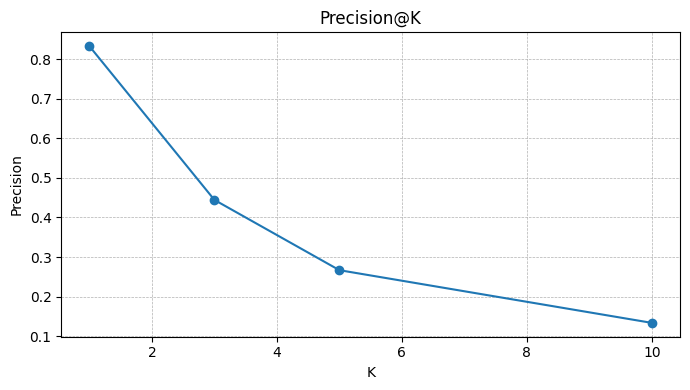

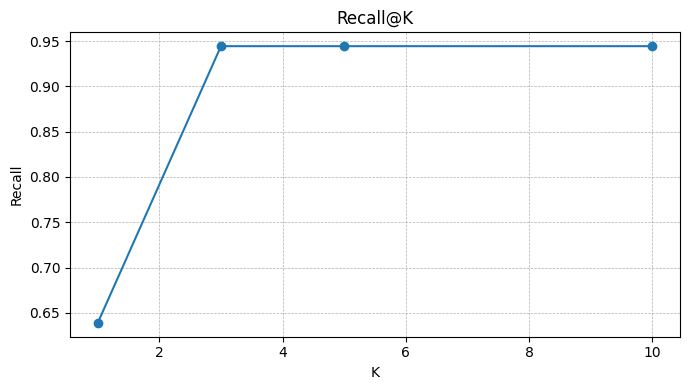

In [83]:
metrics = pd.DataFrame(metrics)

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["precision"], marker="o")
plt.title("Precision@K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["recall"], marker="o")
plt.title("Recall@K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [85]:
vector_path = "files/outputs/recipes-tfidf.joblib"

In [87]:
store = joblib.load(vector_path)
pipeline = store["pipeline"]
vectors = store["vectors"]

In [89]:
print(metadatas[:3])

[{'id': 'bc236e4f-3182-4ee7-9d31-b078d7f3cc01', 'row': 0, 'title': 'Reeses Cups(Candy)  '}, {'id': '2af18621-48a6-4864-85a9-dabd323a8626', 'row': 1, 'title': 'Rhubarb Coffee Cake'}, {'id': 'e7fa8c4c-2729-4bd3-b16e-a5c3c0f4b6c2', 'row': 2, 'title': 'Quick Barbecue Wings'}]


In [90]:
def retrieve_text_tfidf(query, k = total_k):
    qv = pipeline.transform([query])
    
    scores = (vectors @ qv.T).toarray().ravel()
    idx = np.argsort(-scores)[:k]

    hits = []
    for i in idx:
        score = scores[i]
        metadata = metadatas[i]
        hits.append({"score": float(score), "id": metadata["id"], "row": metadata["row"], "title": metadata["title"]})

    return hits

In [91]:
answers = {}

start_time = time.time()
for q in truths.keys():
    hits = retrieve_text_tfidf(q, 10)
    
    rows = []
    for h in hits:
        id = h["id"]
        row = h["row"]

        rows.append(row)

    answers[q] = rows

end_time = time.time()
print(end_time - start_time)
print(answers)

1.1930413246154785
{'How to make Pumpkin Bars with Microwave?': [17003, 19107, 7755, 28569, 11422, 25896, 6537, 6598, 15213, 1428], 'Show me how to cook Cold Oven Pound Cake with Chocolate.': [21048, 12435, 19058, 28133, 9879, 27986, 3895, 28458, 18306, 24178], 'How to make banana oatmeal cookies? I have allergy.': [25567, 20418, 8970, 13579, 20971, 1746, 18015, 19851, 13961, 6598], 'How to make banana oatmeal cookies for people with diabetic': [25567, 8970, 13579, 15912, 6406, 20971, 19851, 18015, 13961, 6598], 'How to cook indian beef curry?': [21602, 6598, 22165, 27704, 8484, 20563, 11510, 24474, 20969, 19227], 'How to cook fish chowder with oven?': [16745, 15817, 3757, 16452, 13255, 17658, 27843, 25387, 24195, 28523]}


In [92]:
metrics = []
for k in [1, 3, 5, 10]:
    precisions, recalls = precision_recall_at_k(truths, answers, k)

    p_vals = []
    r_vals = []

    for p in precisions:
        p_vals.append(p["precision"])

    for r in recalls:
        r_vals.append(r["recall"])

    avg_p = float(np.mean(p_vals))
    avg_r = float(np.mean(r_vals))

    metrics.append({
        "k": k,
        "precision": avg_p,
        "recall": avg_r
    })

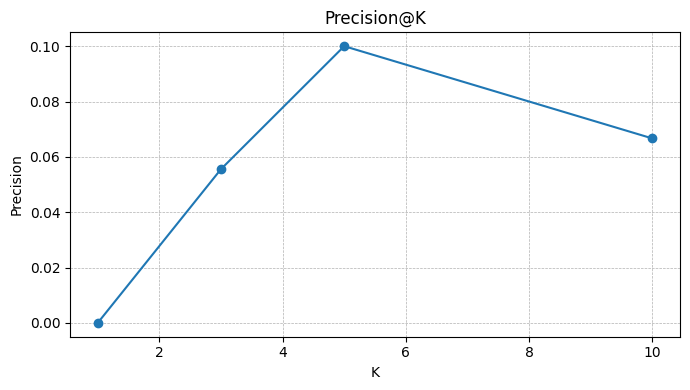

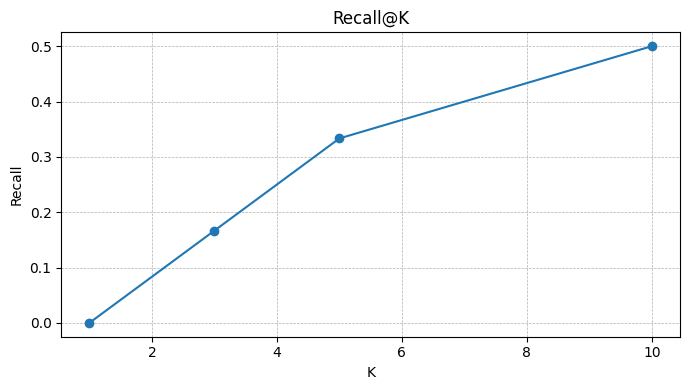

In [93]:
metrics = pd.DataFrame(metrics)

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["precision"], marker="o")
plt.title("Precision@K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(metrics["k"], metrics["recall"], marker="o")
plt.title("Recall@K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()